# Laboratorio 1

In [4]:
#Instalcion de todas las librerias
import pandas as pd
import numpy as np
import sys
from sklearn.base import BaseEstimator, ClassifierMixin
import matplotlib.pyplot as plt
import seaborn as sb


### Carga de datos

In [5]:
# Uso de la libreria pandas para la lectura de archivos
data=pd.read_csv('train_data.csv', sep=',', encoding = 'utf-8')
# Asignación a una nueva variable de los datos leidos
data_t=data

In [6]:
data_t

,objid,ra,dec,u,g,r,i,z,run,camcol,field,score,clean,class,redshift,mjd,rowv,colv
0,1237648722306924571,185.574486,0.701402,19.11034,17.62099,17.03464,16.82993,16.71711,756,5,466,0.864145,1,STAR,8.780529e-05,54140,0.002418,0.001363
1,1237648720167436418,203.801841,-0.853906,18.90957,17.62940,17.01465,16.62059,16.35239,756,1,588,0.816541,1,GALAXY,8.619995e-02,51955,0.008650,0.007056
2,1237648720685105352,160.034264,-0.421626,19.26340,17.67693,16.82551,16.42307,16.13864,756,2,295,0.870381,1,GALAXY,1.330486e-01,51913,0.003938,-0.002028
3,1237648703510937836,200.807373,-0.682024,18.82022,17.77765,17.38575,17.11128,16.93540,752,2,382,0.867801,1,GALAXY,8.636355e-02,51959,0.001839,0.001160
4,1237648720161275992,189.792404,-1.001480,18.91391,19.05355,19.46278,19.75660,20.09613,756,1,494,0.833824,1,STAR,-4.090000e-08,54562,0.001929,-0.000465
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,1237648720690741273,172.826005,-0.484303,18.81890,17.89273,17.54372,17.41363,17.31821,756,2,381,0.887803,1,STAR,1.521540e-04,54891,0.000675,0.000324
3996,1237649918427267086,11.165126,13.745240,17.46665,15.96142,15.36014,15.14572,15.04453,1035,1,38,0.844826,1,STAR,4.182837e-05,53242,-0.000440,-0.000301
3997,1237648720164684046,197.579529,-0.971573,19.45682,18.32555,17.86916,17.57512,17.41648,756,1,546,0.819151,1,GALAXY,8.160563e-02,51985,0.011348,0.005854
3998,1237648721206575779,124.877626,-0.048110,19.20158,17.31450,16.36573,15.91760,15.57736,756,3,60,0.894044,1,GALAXY,8.744828e-02,55888,-0.004486,-0.006072


## Entendimiento de los Datos

Antes de comenzar a analizar los datos, es fundamental identificar cuáles son más importantes que otros.

###  Variables Necesarias

- **ra (Ascensión recta)**
  - Indica la posición del objeto en el cielo.
- **dec (Declinación)**
  - Complementa la posición del objeto en coordenadas celestes.
- **u, g, r, z, i (Magnitudes en diferentes filtros)**
  - Permiten clasificar y caracterizar los objetos en función de su emisión de luz en distintos rangos de longitud de onda.
  - Son fundamentales para estimar redshifts fotométricos si se quiere hacer una estimación sin espectroscopía.
- **class**
  - Indica si el objeto es una estrella (**STAR**), una galaxia (**GALAXY**) o un cuásar (**QSO**).
  - Importante porque el redshift se aplica principalmente a galaxias y cuásares.
- **redshift**
  - Es el valor clave de estudio, ya que representa el corrimiento al rojo del objeto.


###  Variables no necesarias

- **mjd (Día juliano)**
  - Puede ser útil si se estudian variaciones en observaciones a lo largo del tiempo.
- **run**
    - Es la cantidad de observaciones realizadas por el telescopio pero en este caso no es importante
- **camcol**
    - Columna de la cámara en la que se registró el objeto. Se reviso la correlacion lineal pero fue muy bajo tambien por eso se descarto esto.     
 - **field**
    - Sección de la columna de la cámara en la que se registró el objeto. Ya que Camcol no la tomamos importante esta tampoco para el analisis      
- **score**
  - Indica la calidad de la observación. Podría ser útil para filtrar datos de baja calidad.
- **clean**
  - También puede ayudar a filtrar observaciones con problemas en la fotometría.
- **rowv y colv**
  - Indican velocidades en grados/día, que pueden ser útiles si se quiere analizar movimiento propio, pero no son necesarias para un análisis del redshift.




In [16]:
outliers3 = data_t[(data_t['score'] < 0.4) & (data_t["clean"] == 0)]
outliers3


,objid,ra,dec,u,g,r,i,z,run,camcol,field,score,clean,class,redshift,mjd,rowv,colv
655,1237648675605381513,242.727899,1.120734,17.87721,16.59167,15.95641,15.56669,15.33162,745,6,561,0.335453,0,GALAXY,0.058042,51690,0.002712,-0.003092
844,1237648675605119520,242.186567,1.078929,18.87871,17.66926,17.05803,16.73153,16.41729,745,6,557,0.337165,0,GALAXY,0.027761,51690,-0.018714,-0.005424
1430,1237648675606691884,245.663603,1.247618,18.91944,17.80179,17.39375,17.17265,17.08438,745,6,581,0.360785,0,GALAXY,0.024527,52000,0.055092,-0.006479
2325,1237648675605119332,242.104730,1.107362,19.35062,17.90006,17.33493,16.98621,16.73307,745,6,557,0.337165,0,GALAXY,0.081448,51690,0.003924,0.012034
2388,1237648675605119699,242.103892,1.135321,19.51914,18.35248,17.83754,17.54294,17.34665,745,6,557,0.337165,0,GALAXY,0.055745,51690,0.033918,-0.009711
3213,1237648675605381419,242.690510,1.215066,18.75865,17.75045,17.32770,17.08130,16.96067,745,6,561,0.335453,0,GALAXY,0.027967,51690,0.030814,-0.010675
3229,1237648675604660569,241.079456,1.138517,17.79020,16.62802,16.15077,15.85967,15.65650,745,6,550,0.325931,0,GALAXY,0.048070,51693,-0.021055,-0.037280
3501,1237648675604201503,239.974598,1.080736,19.00193,17.77284,17.19768,16.95445,16.83185,745,6,543,0.317932,0,S,-0.000125,51692,0.002345,0.009297
3608,1237648675607019707,246.488344,1.182788,18.29642,17.28916,16.95478,16.80289,16.76402,745,6,586,0.360414,0,STAR,-0.000201,52000,0.000846,0.002011


In [216]:
#Entendimiento del tamaño del data Set a ser manejado
print('Dimensiones de los datos: ', data_t.shape, 'El primer valor corresponde a filas y el segundo a columnas')

Dimensiones de los datos:  (4000, 18) El primer valor corresponde a filas y el segundo a columnas


In [217]:
# Visualizacion de los primeros 10 datos
display(data_t.head(10))

,objid,ra,dec,u,g,r,i,z,run,camcol,field,score,clean,class,redshift,mjd,rowv,colv
0,1237648722306924571,185.574486,0.701402,19.11034,17.62099,17.03464,16.82993,16.71711,756,5,466,0.864145,1,STAR,8.780529e-05,54140,0.002418,0.001363
1,1237648720167436418,203.801841,-0.853906,18.90957,17.62940,17.01465,16.62059,16.35239,756,1,588,0.816541,1,GALAXY,8.619995e-02,51955,0.008650,0.007056
2,1237648720685105352,160.034264,-0.421626,19.26340,17.67693,16.82551,16.42307,16.13864,756,2,295,0.870381,1,GALAXY,1.330486e-01,51913,0.003938,-0.002028
3,1237648703510937836,200.807373,-0.682024,18.82022,17.77765,17.38575,17.11128,16.93540,752,2,382,0.867801,1,GALAXY,8.636355e-02,51959,0.001839,0.001160
4,1237648720161275992,189.792404,-1.001480,18.91391,19.05355,19.46278,19.75660,20.09613,756,1,494,0.833824,1,STAR,-4.090000e-08,54562,0.001929,-0.000465
5,1237648720132178408,123.386052,-1.045499,18.52214,17.45173,17.23112,17.16427,17.13214,756,1,50,0.851417,1,STAR,1.190440e-05,53816,-0.002165,-0.000364
6,1237648720165863598,200.243728,-0.895931,18.09523,16.82764,16.18942,15.83503,15.58671,756,1,564,0.815295,0,GALAXY,4.815651e-02,51984,-0.011610,0.002361
7,1237648704054624442,216.256661,-0.220799,19.20765,18.73173,18.84302,18.98353,19.15128,752,3,486,0.804086,1,STAR,-2.234210e-04,51613,-0.002153,-0.001026
8,1237648722308890870,190.050847,0.695672,17.82951,15.90091,15.02515,14.61881,14.30353,756,5,496,0.822898,1,GALAXY,4.634102e-02,51941,-0.000474,-0.001548
9,1237648720163963081,195.951990,-0.966005,17.76132,16.51327,15.89811,15.53069,15.31236,756,1,535,0.811336,1,GALAXY,8.944633e-02,51986,0.000894,0.001024


In [218]:
# Imprimimos los diferentes tipos de las columnas
data_t.dtypes

objid         int64
ra          float64
dec         float64
u           float64
g           float64
r           float64
i           float64
z           float64
run           int64
camcol        int64
field         int64
score       float64
clean         int64
class        object
redshift    float64
mjd           int64
rowv        float64
colv        float64
dtype: object

In [219]:
# Imprimir las columnas numericas
columnasNumericas= data_t.select_dtypes(include=['int','float']).columns
print(columnasNumericas)

Index(['objid', 'ra', 'dec', 'u', 'g', 'r', 'i', 'z', 'run', 'camcol', 'field',
       'score', 'clean', 'redshift', 'mjd', 'rowv', 'colv'],
      dtype='object')


In [220]:
data_t.describe( include='all')

,objid,ra,dec,u,g,r,i,z,run,camcol,field,score,clean,class,redshift,mjd,rowv,colv
count,4.000000e+03,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.00000,4000.000000,4000.000000,4000.000000,4000,4000.000000,4000.000000,4000.000000,4000.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GALAXY,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1857,NaN,NaN,NaN,NaN
mean,1.237649e+18,185.523295,0.248959,18.609049,17.363397,16.839856,16.597712,16.439392,743.829000,3.37625,419.602000,0.851765,0.895500,NaN,0.134015,52957.124750,0.000218,-0.000090
std,4.244222e+11,41.689446,2.001075,0.839431,0.950964,1.055343,1.141252,1.190502,98.865936,1.69909,167.162063,0.071311,0.305946,NaN,0.379742,1601.148131,0.008794,0.007457
min,1.237646e+18,10.469743,-1.252763,13.551780,12.974870,12.362850,12.010790,11.799530,211.000000,1.00000,19.000000,0.301912,0.000000,NaN,-0.003322,51608.000000,-0.264516,-0.168807
25%,1.237649e+18,162.474666,-0.631824,18.170375,16.796110,16.190785,15.870782,15.628205,752.000000,2.00000,311.000000,0.836866,1.000000,NaN,0.000106,51821.000000,-0.001212,-0.001609
50%,1.237649e+18,195.815451,0.053336,18.843745,17.472525,16.850835,16.571195,16.402665,756.000000,3.00000,434.000000,0.860675,1.000000,NaN,0.032038,51986.000000,0.000322,0.000125
75%,1.237649e+18,214.348425,0.593396,19.261563,17.997818,17.506640,17.258833,17.147037,756.000000,5.00000,527.000000,0.879834,1.000000,NaN,0.086479,54468.000000,0.001698,0.001672


### Ahora vamos a empezar a revisar los datos que se encuentran mal de cada columna en base a sus datos para ver si se pueden corregir o deben de ser eliminados

In [221]:
#Para empezar revisamos si hay valores nulos en el dataset, pero no se encuentran datos nulos
data_t.isnull().sum()

objid       0
ra          0
dec         0
u           0
g           0
r           0
i           0
z           0
run         0
camcol      0
field       0
score       0
clean       0
class       0
redshift    0
mjd         0
rowv        0
colv        0
dtype: int64

In [222]:
# Ver las filas duplicadas
duplicados = data_t[data_t.duplicated()]

# Para ver tanto las filas originales como sus duplicados:
duplicados_todos = data_t[data_t.duplicated(keep=False)]

# Para ver cuántas filas duplicadas hay:
num_duplicados = data_t.duplicated().sum()

# Para ver un resumen más detallado:
print(f"Total de filas duplicadas: {data_t.duplicated().sum()}")


Total de filas duplicadas: 17


### Revisando la Columna 'ra' la cual describe Ubicación del objeto en su componente de ascensión recta de coordenada celeste.

In [223]:
data['ra'].describe()

count    4000.000000
mean      185.523295
std        41.689446
min        10.469743
25%       162.474666
50%       195.815451
75%       214.348425
max       249.758313
Name: ra, dtype: float64

In [224]:
#Revisar si hay datos Nulos en la columna ra
data['ra'].isna().sum()

0

In [225]:
# Ya que Ra describe la ubicación del objeto en su componente de ascensión recta de coordenada celeste. Este valor debe de estar entre 0 y 360 grados.
df_out_rango = data_t[(data_t["ra"] < 0) | (data_t["ra"] > 360)]
print(df_out_rango)

Empty DataFrame
Columns: [objid, ra, dec, u, g, r, i, z, run, camcol, field, score, clean, class, redshift, mjd, rowv, colv]
Index: []


162.474665625 214.348425475 51.87375985
84.66402585 292.15906525


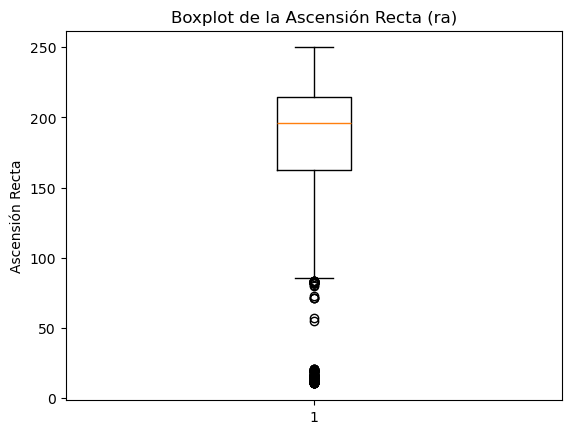

In [226]:
#Revisamos si se encuentra dentro del rango intercuartil, los valores que se encuentren por fuera de esto son outlayers [Q1−1.5×IQR,Q3+1.5×IQR]

Q1 = data_t['ra'].quantile(0.25)
Q3 = data_t['ra'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print(Q1,Q3,IQR)
print(lower_bound,upper_bound) 
 
outliers = data_t[(data_t['ra'] < lower_bound) | (data_t['ra'] > upper_bound)]
# print(outliers['ra'])
outliers
plt.boxplot(data_t['ra'])
plt.title("Boxplot de la Ascensión Recta (ra)")
plt.ylabel("Ascensión Recta")
plt.show()

PENDIENTE PONER EN TIPO MARKDOWN
Distribución General:
La mediana (línea naranja) se encuentra cerca del centro del cajón, indicando que la distribución no está demasiado sesgada.
La mayoría de los datos se encuentran en el rango intercuartil (IQR), entre el primer y tercer cuartil.
Valores Atípicos (Outliers):
Se observan varios outliers en la parte inferior, lo que sugiere que hay valores significativamente bajos de ascensión recta en comparación con la mayoría de los datos.
Algunos de estos valores están bastante lejos del límite inferior del bigote, indicando que podrían ser errores de medición o registros especiales que deben analizarse más a fondo.
Límites de los Bigotes:
El límite inferior del bigote está alrededor de 90 pero hay valores por debajo de 50, que se consideran atípicos según el método del IQR.
El límite superior está alrededor de 250, sin outliers significativos en esta dirección, lo que sugiere que los valores altos no presentan anomalías.

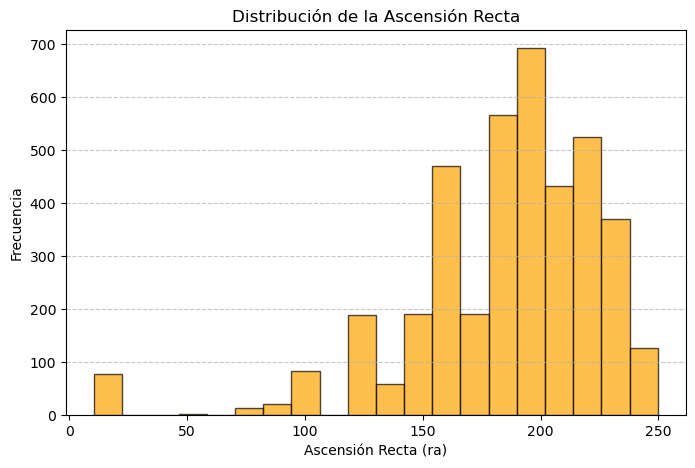

In [227]:
# Crear el histograma para visualizar la distribución de 'ra'
plt.figure(figsize=(8, 5))
plt.hist(data_t["ra"], bins=20, edgecolor="black", alpha=0.7, color="orange")
plt.xlabel("Ascensión Recta (ra)")
plt.ylabel("Frecuencia")
plt.title("Distribución de la Ascensión Recta")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

In [228]:
# for col in data_t.select_dtypes(include=['object']):
#     print(f"Valores únicos en {col}:\n", data_t[col].unique())

## Columna dec
Describe: Ubicación del objeto en su componente de declinación de coordenada celeste.

In [229]:
data_t['dec'].describe()

count    4000.000000
mean        0.248959
std         2.001075
min        -1.252763
25%        -0.631824
50%         0.053336
75%         0.593396
max        13.854010
Name: dec, dtype: float64

In [230]:
#Ya que Dec describe la ubicación del objeto en su componente de declinación de coordenada celeste. Este valor debe de estar entre -90 y 90 grados.
out_rango = data_t[(data_t["dec"] < -90) | (data_t["dec"] > 90)]
print(out_rango)

Empty DataFrame
Columns: [objid, ra, dec, u, g, r, i, z, run, camcol, field, score, clean, class, redshift, mjd, rowv, colv]
Index: []


-0.631823884 0.59339562175 1.2252195057500002
-2.4696531426250004 2.4312248803750003


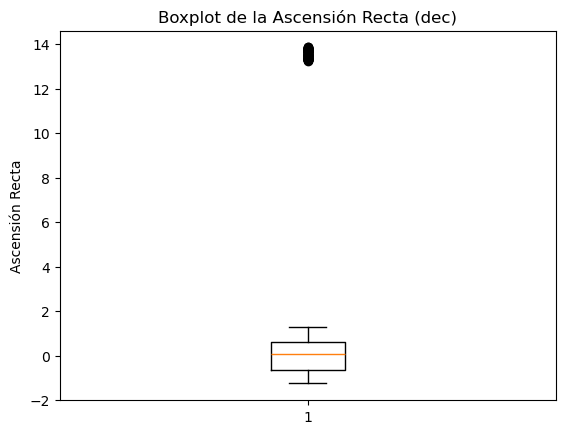

In [231]:
Q1 = data_t['dec'].quantile(0.25)
Q3 = data_t['dec'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print(Q1,Q3,IQR)
print(lower_bound,upper_bound) 
 
outliers = data_t[(data_t['dec'] < lower_bound) | (data_t['dec'] > upper_bound)]
# print(outliers['dec'])
outliers
plt.boxplot(data_t['dec'])
plt.title("Boxplot de la Ascensión Recta (dec)")
plt.ylabel("Ascensión Recta")
plt.show()


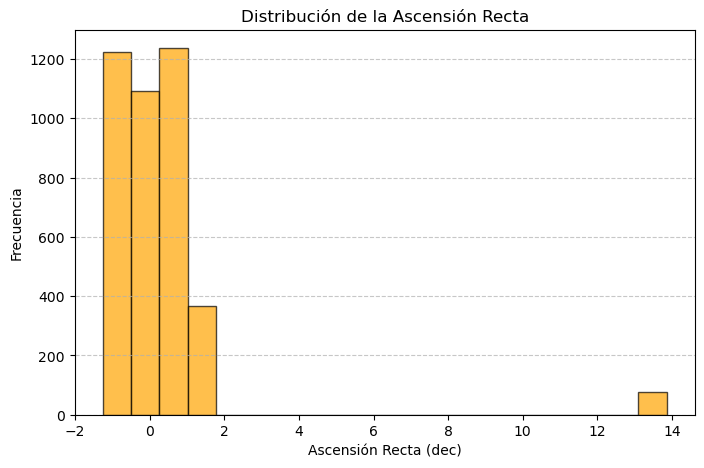

In [232]:
plt.figure(figsize=(8, 5))
plt.hist(data_t["dec"], bins=20, edgecolor="black", alpha=0.7, color="orange")
plt.xlabel("Ascensión Recta (dec)")
plt.ylabel("Frecuencia")
plt.title("Distribución de la Ascensión Recta")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

### Vamos a revisar ese dato que se sale de la asension de la recta normal

In [233]:
# Valores a revisar ya que son valores lejos del centro
outliers2 = data_t[(data_t['dec'] > 10)]
outliers2

,objid,ra,dec,u,g,r,i,z,run,camcol,field,score,clean,class,redshift,mjd,rowv,colv
29,1237649918428708879,14.607180,13.658038,16.82643,15.43794,14.98633,14.71074,14.70645,1035,1,60,0.837125,0,STAR,-0.000091,51821,0.001621,-0.005480
67,1237649918427529256,11.841490,13.758000,18.99192,17.76341,17.20069,16.95889,16.83418,1035,1,42,0.839663,1,STAR,-0.000242,54746,0.000861,0.000812
122,1237649918430675099,19.289872,13.307634,19.39130,17.31409,16.24925,15.80192,15.41582,1035,1,90,0.839906,1,GALAXY,0.122100,51821,0.001001,-0.000596
140,1237649918427463866,11.755019,13.699373,19.58155,18.49723,17.68913,17.24281,16.94974,1035,1,41,0.832880,1,GALAXY,0.166697,51879,-0.005315,-0.003441
189,1237649918427332774,11.414186,13.701465,18.42381,16.56606,15.62659,15.14680,14.78974,1035,1,39,0.847706,1,GALAXY,0.078500,51879,-0.005236,-0.003954
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3654,1237649918427660313,12.091733,13.766811,17.67724,16.00506,15.37426,15.16362,15.06272,1035,1,44,0.832172,1,STAR,-0.000099,53242,-0.000196,-0.000026
3739,1237649918428119075,13.239400,13.802962,18.17234,16.91165,16.45018,16.23590,16.15311,1035,1,51,0.844826,1,STAR,-0.000237,51871,0.001060,0.002007
3759,1237649918431395974,20.967766,13.293768,18.24642,17.08067,16.65181,16.34302,16.19559,1035,1,101,0.827463,1,GALAXY,0.073396,51893,0.000133,0.002385
3883,1237649918427267203,11.165981,13.783440,19.52778,18.48113,18.06105,17.88715,17.78468,1035,1,38,0.844826,1,STAR,-0.000849,54746,-0.000632,-0.000024


## Columna U
Magnitud del objeto capturada en el filtro ultravioleta. Valor mayor a 0.

In [234]:
data_t['u'].describe()

count    4000.000000
mean       18.609049
std         0.839431
min        13.551780
25%        18.170375
50%        18.843745
75%        19.261563
max        19.599750
Name: u, dtype: float64

In [235]:
# Revisamos si es que existen valores por debajo del 0 
outliers = data_t[(data_t['u'] <= 0)]
outliers

,objid,ra,dec,u,g,r,i,z,run,camcol,field,score,clean,class,redshift,mjd,rowv,colv


In [236]:
# Revisamos si es que existen valores por encima de 30, pq Normalmente, las magnitudes de objetos astronómicos en el filtro ultravioleta están en un rango entre -5 y 25.
outliers = data_t[(data_t['u'] > 30)]
outliers

,objid,ra,dec,u,g,r,i,z,run,camcol,field,score,clean,class,redshift,mjd,rowv,colv


18.170375 19.2615625 1.0911875000000002
16.53359375 20.898343750000002


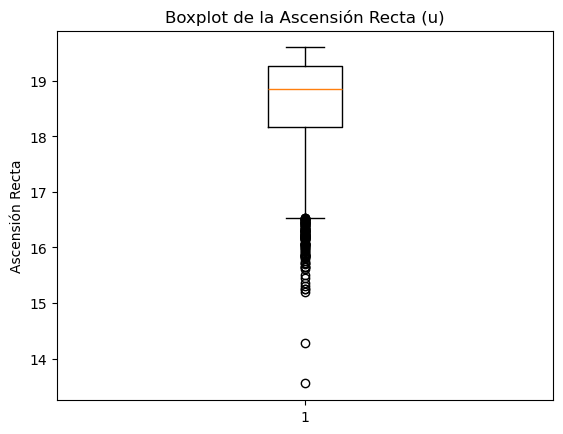

In [237]:
Q1 = data_t['u'].quantile(0.25)
Q3 = data_t['u'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print(Q1,Q3,IQR)
print(lower_bound,upper_bound) 
 
outliers = data_t[(data_t['u'] < lower_bound) | (data_t['u'] > upper_bound)]
# print(outliers['dec'])
outliers
plt.boxplot(data_t['u'])
plt.title("Boxplot de la Ascensión Recta (u)")
plt.ylabel("Ascensión Recta")
plt.show()


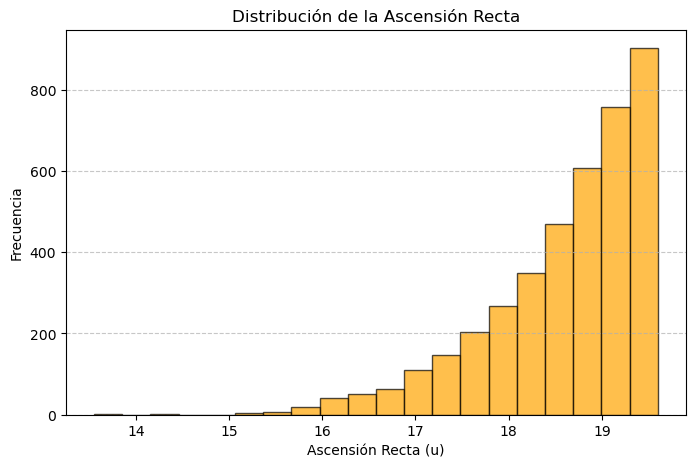

In [238]:
plt.figure(figsize=(8, 5))
plt.hist(data_t["u"], bins=20, edgecolor="black", alpha=0.7, color="orange")
plt.xlabel("Ascensión Recta (u)")
plt.ylabel("Frecuencia")
plt.title("Distribución de la Ascensión Recta")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

## Columna g
Describe: Ubicación del objeto en su componente de declinación de coordenada celeste.

In [239]:
data_t['g'].describe()

count    4000.000000
mean       17.363397
std         0.950964
min        12.974870
25%        16.796110
50%        17.472525
75%        17.997818
max        22.497450
Name: g, dtype: float64

In [240]:
#Ya que g describe la magnitud del objeto en el filtro verde este va entre 12-25
out_rango = data_t[(data_t["g"] > 25) | (data_t["g"] < 12)]
print(out_rango)

Empty DataFrame
Columns: [objid, ra, dec, u, g, r, i, z, run, camcol, field, score, clean, class, redshift, mjd, rowv, colv]
Index: []


In [241]:
menor0 = data_t[(data_t["g"] <= 0)]
print(menor0)

Empty DataFrame
Columns: [objid, ra, dec, u, g, r, i, z, run, camcol, field, score, clean, class, redshift, mjd, rowv, colv]
Index: []


16.79611 17.9978175 1.2017075000000013
14.993548749999997 19.80037875


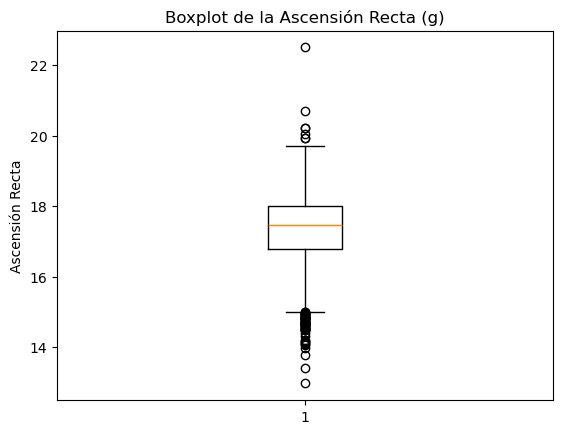

In [242]:
Q1 = data_t['g'].quantile(0.25)
Q3 = data_t['g'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print(Q1,Q3,IQR)
print(lower_bound,upper_bound) 
 
outliers = data_t[(data_t['g'] < lower_bound) | (data_t['g'] > upper_bound)]
# print(outliers['g'])
outliers
plt.boxplot(data_t['g'])
plt.title("Boxplot de la Ascensión Recta (g)")
plt.ylabel("Ascensión Recta")
plt.show()

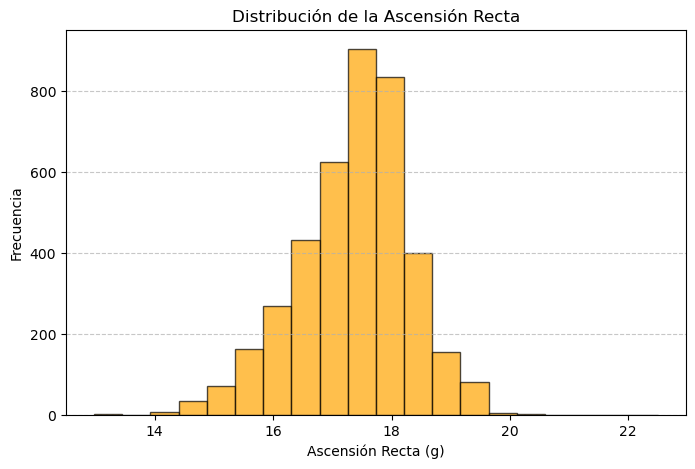

In [243]:
plt.figure(figsize=(8, 5))
plt.hist(data_t["g"], bins=20, edgecolor="black", alpha=0.7, color="orange")
plt.xlabel("Ascensión Recta (g)")
plt.ylabel("Frecuencia")
plt.title("Distribución de la Ascensión Recta")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

## Columna r
Describe: Magnitud del objeto capturada en el filtro rojo. Valor mayor a 0.

In [244]:
data_t['r'].describe()

count    4000.000000
mean       16.839856
std         1.055343
min        12.362850
25%        16.190785
50%        16.850835
75%        17.506640
max        22.265960
Name: r, dtype: float64

In [245]:
menor0 = data_t[(data_t["r"] <= 0)]
print(menor0)

Empty DataFrame
Columns: [objid, ra, dec, u, g, r, i, z, run, camcol, field, score, clean, class, redshift, mjd, rowv, colv]
Index: []


## Columna z
Describe: Magnitud del objeto capturada en el filtro casi-infrarrojo. Valor mayor a 0.

In [246]:
data_t['z'].describe()

count    4000.000000
mean       16.439392
std         1.190502
min        11.799530
25%        15.628205
50%        16.402665
75%        17.147037
max        20.847690
Name: z, dtype: float64

## Columna i
Describe: Magnitud del objeto capturada en el filtro infrarrojo. Valor mayor a 0.

In [247]:
data_t['i'].describe()

count    4000.000000
mean       16.597712
std         1.141252
min        12.010790
25%        15.870782
50%        16.571195
75%        17.258833
max        28.179630
Name: i, dtype: float64

## Columna score

#### 1. Visualizar como se distribuyen los datos entre 0 y 1 por cuartiles

In [ ]:
data_t['score'].describe()

#### 2. Visualización Gráfica

In [ ]:
# Crear el histograma
plt.figure(figsize=(8, 6))
sb.histplot(data_t['score'], bins=20, kde=True, color='blue', edgecolor='black')
plt.title("Distribución de Score", fontsize=14)
plt.xlabel("Score", fontsize=12)
plt.ylabel("Frecuencia", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()
print("Esto nos dá a entender que la mayoría de las observaciones presentan una alta calidad, además no se presentaron datos fuera del rango 0 - 1")

#### 3. Eliminar datos que tienen una score y un clean 0

Decidimos eliminar ciertos datos con una score y clean bajo ya que no aportan mucho a nuestro analisis

In [ ]:
print(data_t.shape)
data_t = data_t[~((data_t["score"] < 0.4) & (data_t["clean"] == 0))]
print(data_t.shape)

## Columna clean

#### 1. Describir por cuartiles los datos de clean

In [ ]:
data_t['clean'].describe()

#### 2. Análisis grafico para detectar anomalías

In [ ]:
plt.figure(figsize=(6,6))
data_t['clean'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['green', 'red'])

plt.title("Proporción de objetos con fotometría confiable")
plt.ylabel("")
plt.show()
print("Se observa que todos los datos son binarios , es decir 0 o 1, no se detectaron anomalías")

## Columna camcol
Describe: Columna de la cámara en la que se registró el objeto.

camcol
1    800
4    752
5    716
2    633
3    581
6    518
Name: count, dtype: int64
Valores únicos: [5 1 2 3 6 4]


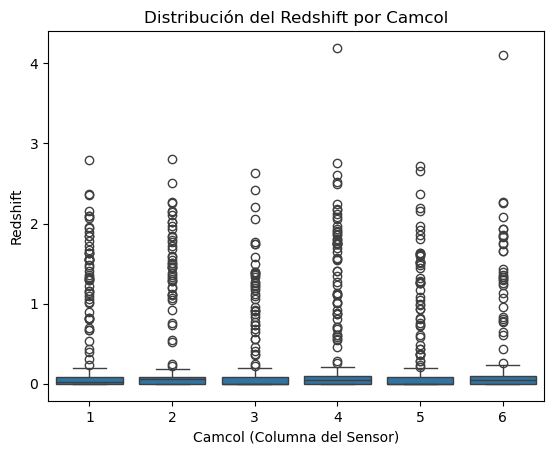

Correlación entre camcol y redshift: -0.003906015457972524


In [7]:
print(data_t['camcol'].value_counts())
print("Valores únicos:", data_t['camcol'].unique())

#Podemos ver que es una columna numerica pero deberia de ser categorica solo toma valores 
# específicos como {1, 2, 3, 4, 5, 6}, es más una categoría que un número
sb.boxplot(x=data_t["camcol"], y=data_t["redshift"])
plt.xlabel("Camcol (Columna del Sensor)")
plt.ylabel("Redshift")
plt.title("Distribución del Redshift por Camcol")
plt.show()
correlation = data_t["camcol"].corr(data_t["redshift"])
print("Correlación entre camcol y redshift:", correlation)

In [249]:
data_t['camcol'] = data_t['camcol'].astype('category')
print("Tipo de dato:", data_t['camcol'].dtype)

Tipo de dato: category


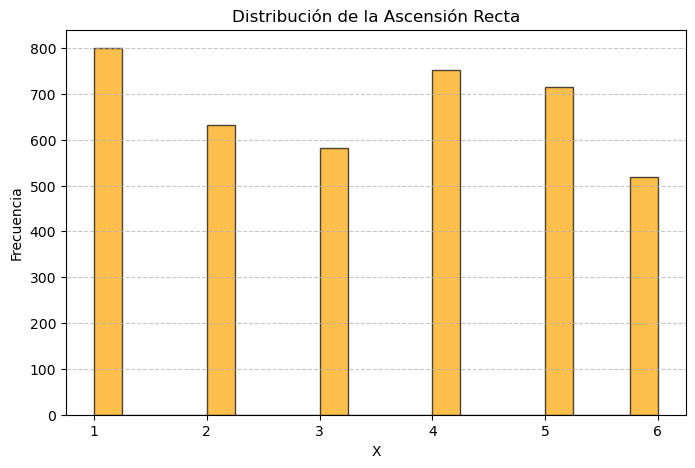

In [250]:
plt.figure(figsize=(8, 5))
plt.hist(data_t["camcol"], bins=20, edgecolor="black", alpha=0.7, color="orange")
plt.xlabel("X")
plt.ylabel("Frecuencia")
plt.title("Distribución de la Ascensión Recta")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()


Analizando la correlación decidimos que no es una variable que influye directamente al redshift entonces la omitimos

## Columna field
Describe: Sección de la columna de la cámara en la que se registró el objeto.


In [251]:
for col in data.columns:
    unique_values = data[col].nunique()
    print(f"{col}: {unique_values} valores únicos")


objid: 3983 valores únicos
ra: 3983 valores únicos
dec: 3983 valores únicos
u: 3952 valores únicos
g: 3953 valores únicos
r: 3963 valores únicos
i: 3959 valores únicos
z: 3968 valores únicos
run: 7 valores únicos
camcol: 6 valores únicos
field: 663 valores únicos
score: 1563 valores únicos
clean: 2 valores únicos
class: 6 valores únicos
redshift: 3932 valores únicos
mjd: 183 valores únicos
rowv: 3979 valores únicos
colv: 3978 valores únicos


## Columna class

#### 1. Revisión de como se distribuyen las clases

In [ ]:
data_t['class'].describe()
print("Valores únicos en 'class':", data_t['class'].unique())
print("\nValores nulos en 'class':", data_t['class'].isnull().sum())

# Ver distribución de las clases
print("\nDistribución de clases:")
print(data_t['class'].value_counts())

#### 2. Como se detectaron anomalías en las clasificaciones , se hace una normalización

En este caso por intuición vamos a tomar los datos de clasificación G y convertirlos GALAXY

In [ ]:
# Reemplazar 'G' por 'GALAXY'
data_t['class'] = data_t['class'].replace('G', 'GALAXY')

Por otro lado para los datos que tienen la clasificación S los modificaremos para que sean STAR

In [ ]:
# Reemplazar 'S' por 'STAR'
data_t['class'] = data_t['class'].replace('S', 'STAR')

Tambien para hacer el uso de solo una etiqueta cambiamos Quasar por QSO

In [ ]:
# Reemplazar 'QUASAR' por 'QSO'
data_t['class'] = data_t['class'].replace('QUASAR', 'QSO')

Luego volvemos a revisar si ya se hicieron los cambios correctamente

In [ ]:
data_t['class'].describe()
print("Valores únicos en 'class':", data_t['class'].unique())
print("\nValores nulos en 'class':", data_t['class'].isnull().sum())

# Ver distribución de las clases
print("\nDistribución de clases:")
print(data_t['class'].value_counts())

#### 3. Transformación para facilitar el modelo de regresión

In [ ]:
data_t = pd.get_dummies(data_t, columns=['class'], prefix='class')

#### 4. Análisis Gráfico de la columna

In [ ]:
# Contar las ocurrencias de cada clase
class_counts = data_t['class'].value_counts()

# Crear el gráfico de barras
plt.figure(figsize=(8, 5))
plt.bar(class_counts.index, class_counts.values, color='skyblue', edgecolor='black')

# Etiquetas y título
plt.xlabel("Tipo de Objeto (class)")
plt.ylabel("Cantidad")
plt.title("Distribución de Tipos de Objetos")
plt.xticks(rotation=45)  # Rotar etiquetas para mejor visibilidad

# Mostrar el gráfico
plt.show()

## Análisis de calidad de los datos

Completitud

In [252]:
# Cálculo de valores nulos por columna
((data_t.isnull().sum()/data_t.shape[0])).sort_values(ascending=False)

objid       0.0
ra          0.0
rowv        0.0
mjd         0.0
redshift    0.0
class       0.0
clean       0.0
score       0.0
field       0.0
camcol      0.0
run         0.0
z           0.0
i           0.0
r           0.0
g           0.0
u           0.0
dec         0.0
colv        0.0
dtype: float64

Al hacer un examen de completitud de los datos podemos ver que no hay datos nulos en ninguna columna del data frame

2.2 Unicidad

In [253]:
data_t.duplicated(keep = False).sum()
print(f"Filas duplicadas: {data_t.duplicated(keep=False).sum()}")

Filas duplicadas: 34


Se identificaron 34 filas duplicadas, ahora vamos a ver a detalle que es lo que está sucediendo

In [254]:
duplicados = data_t.loc[data_t.duplicated(keep=False)]
duplicados

,objid,ra,dec,u,g,r,i,z,run,camcol,field,score,clean,class,redshift,mjd,rowv,colv
88,1237648703513428079,206.374167,-0.781673,18.28101,17.18856,16.70175,16.33173,16.14626,752,2,420,0.904768,1,GALAXY,0.088136,51943,-0.002860,0.001156
109,1237648721231609897,182.015940,-0.116600,17.96686,16.91550,16.75447,16.68648,16.70880,756,3,442,0.876962,1,S,-0.000066,51615,-0.000639,0.000270
114,1237646382079606869,94.679499,0.842321,18.47695,16.94897,16.68126,16.59887,16.51747,211,6,359,0.806204,1,STAR,0.000207,52931,0.000372,-0.001017
299,1237648721756225804,154.036159,0.417930,19.50457,18.08980,17.29931,16.88134,16.56668,756,4,255,0.892071,1,GALAXY,0.096783,51883,-0.000413,-0.002812
629,1237648720687988788,166.623017,-0.546630,19.55528,17.73928,16.86703,16.44810,16.11761,756,2,339,0.879096,1,GALAXY,0.086721,51900,0.001004,-0.001857
642,1237648720715710772,229.932143,-0.607750,18.34448,17.39741,17.08713,16.86085,16.67511,756,2,762,0.846381,1,GALAXY,0.037010,51689,0.004917,-0.009145
718,1237648721789780467,230.664376,0.229439,19.48961,18.21590,17.50523,17.09294,16.87079,756,4,767,0.872553,1,GALAXY,0.112827,51673,0.008122,0.012494
719,1237648721788993889,228.864817,0.317359,18.88618,17.66549,17.09694,16.72708,16.56451,756,4,755,0.881142,1,GALAXY,0.082665,51689,-0.003803,-0.000683
856,1237648705679065271,247.896821,0.990909,16.74659,15.61752,15.43460,15.40196,15.40794,752,6,697,0.842783,1,STAR,0.000073,51671,0.002149,-0.000930
897,1237646382079672642,94.883887,0.990686,17.03847,15.47224,15.10297,14.97051,14.88297,211,6,360,0.806983,1,S,0.000012,52931,-0.001483,0.001376


Viendo a detalle los datos se puede ver que hay filas completamente duplicadas. Analizando el contexto de los datos y la forma en que se toman no tiene sentido que hayan filas completamente duplicadas, por lo cual consideramos eliminarlas. Eliminaremos 17 filas ya que estas corresponden a las filas duplicadas

2.3 Consistencia 

2.4 Validez

## Visualización de datos

array([[<Axes: title={'center': 'objid'}>,
        <Axes: title={'center': 'ra'}>, <Axes: title={'center': 'dec'}>,
        <Axes: title={'center': 'u'}>],
       [<Axes: title={'center': 'g'}>, <Axes: title={'center': 'r'}>,
        <Axes: title={'center': 'i'}>, <Axes: title={'center': 'z'}>],
       [<Axes: title={'center': 'run'}>,
        <Axes: title={'center': 'field'}>,
        <Axes: title={'center': 'score'}>,
        <Axes: title={'center': 'clean'}>],
       [<Axes: title={'center': 'redshift'}>,
        <Axes: title={'center': 'mjd'}>,
        <Axes: title={'center': 'rowv'}>,
        <Axes: title={'center': 'colv'}>]], dtype=object)

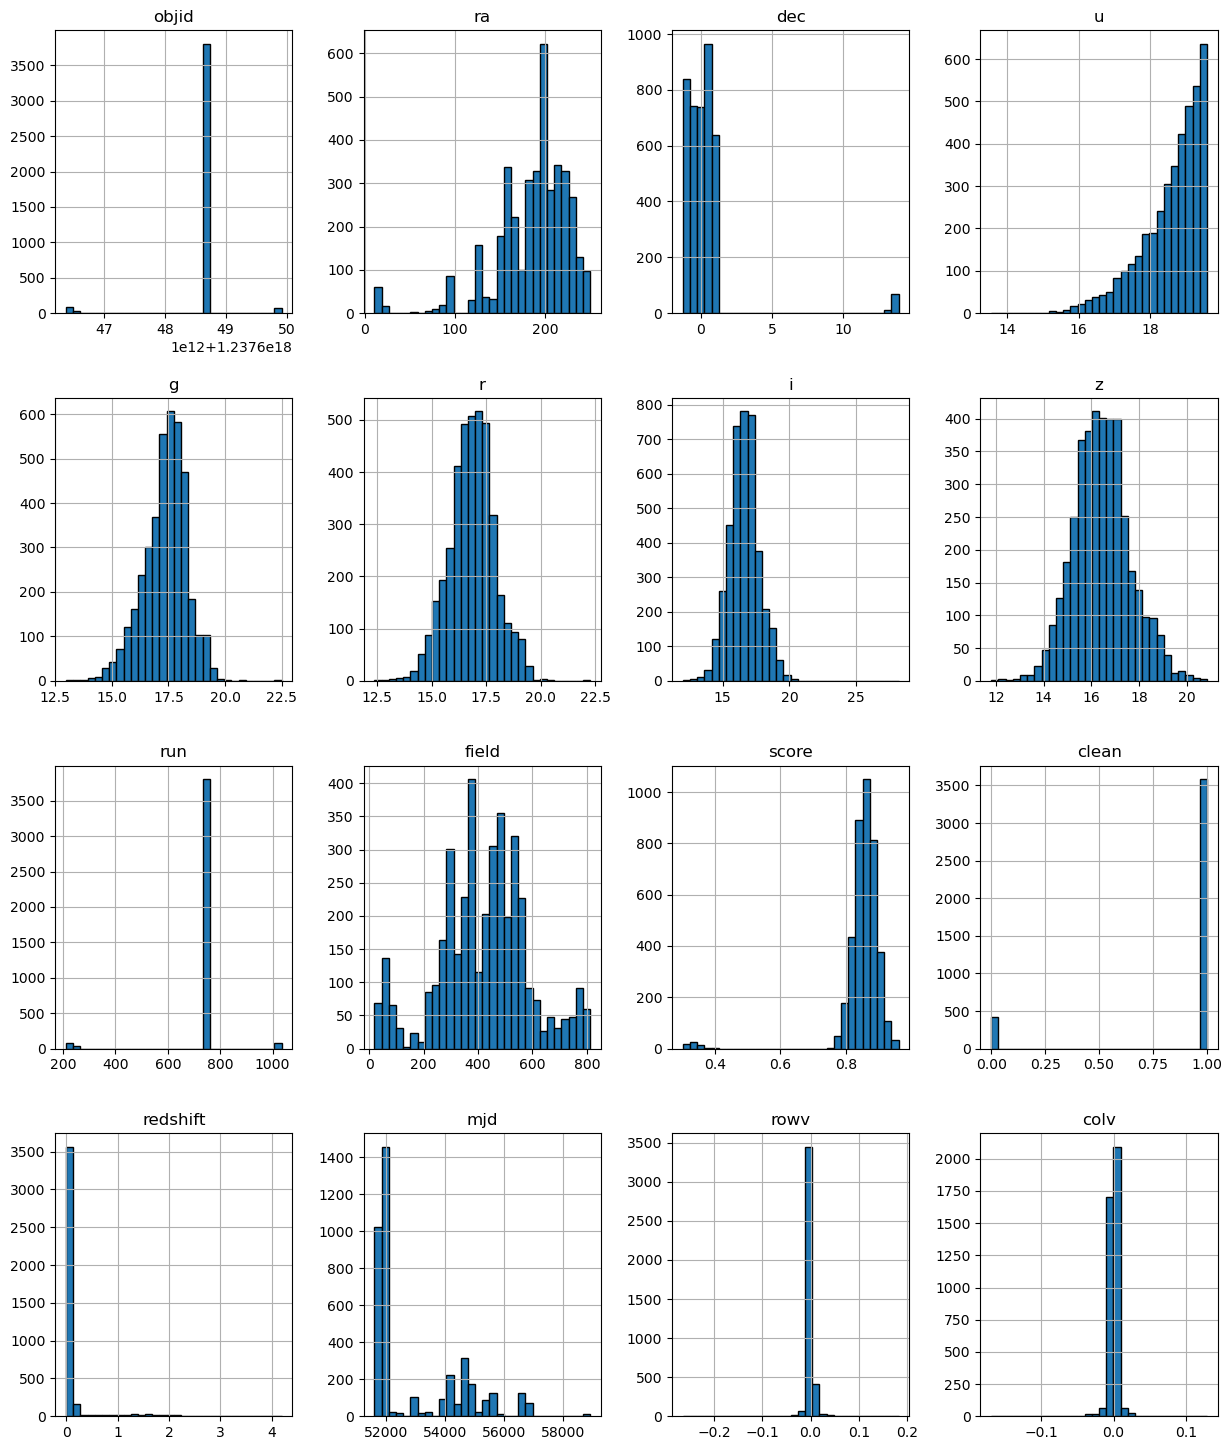

In [255]:
data_t.hist(figsize=(15,18),bins=30,edgecolor="black")

Análisis de correlaciones

In [256]:
data_t["camcol"].value_counts()

camcol
1    800
4    752
5    716
2    633
3    581
6    518
Name: count, dtype: int64

In [257]:
data_t["class"].value_counts()

class
GALAXY    1857
STAR      1629
QSO        292
S          177
G           44
QUASAR       1
Name: count, dtype: int64

One-Hot encoding

In [258]:
dumies1=pd.get_dummies(data_t["camcol"], dtype=int)
data_t=pd.concat([data_t, dumies1], axis=1)


In [259]:
dumies2=pd.get_dummies(data_t["class"], dtype=int)
data_t=pd.concat([data_t, dumies2], axis=1)

In [260]:
data_t=data_t.drop(["class"],axis=1)
data_t=data_t.drop(["camcol"],axis=1)

In [261]:
data_t.head()

,objid,ra,dec,u,g,r,i,z,run,field,...,3,4,5,6,G,GALAXY,QSO,QUASAR,S,STAR
0,1237648722306924571,185.574486,0.701402,19.11034,17.62099,17.03464,16.82993,16.71711,756,466,...,0,0,1,0,0,0,0,0,0,1
1,1237648720167436418,203.801841,-0.853906,18.90957,17.62940,17.01465,16.62059,16.35239,756,588,...,0,0,0,0,0,1,0,0,0,0
2,1237648720685105352,160.034264,-0.421626,19.26340,17.67693,16.82551,16.42307,16.13864,756,295,...,0,0,0,0,0,1,0,0,0,0
3,1237648703510937836,200.807373,-0.682024,18.82022,17.77765,17.38575,17.11128,16.93540,752,382,...,0,0,0,0,0,1,0,0,0,0
4,1237648720161275992,189.792404,-1.001480,18.91391,19.05355,19.46278,19.75660,20.09613,756,494,...,0,0,0,0,0,0,0,0,0,1


Análisis de correlaciones

<Axes: >

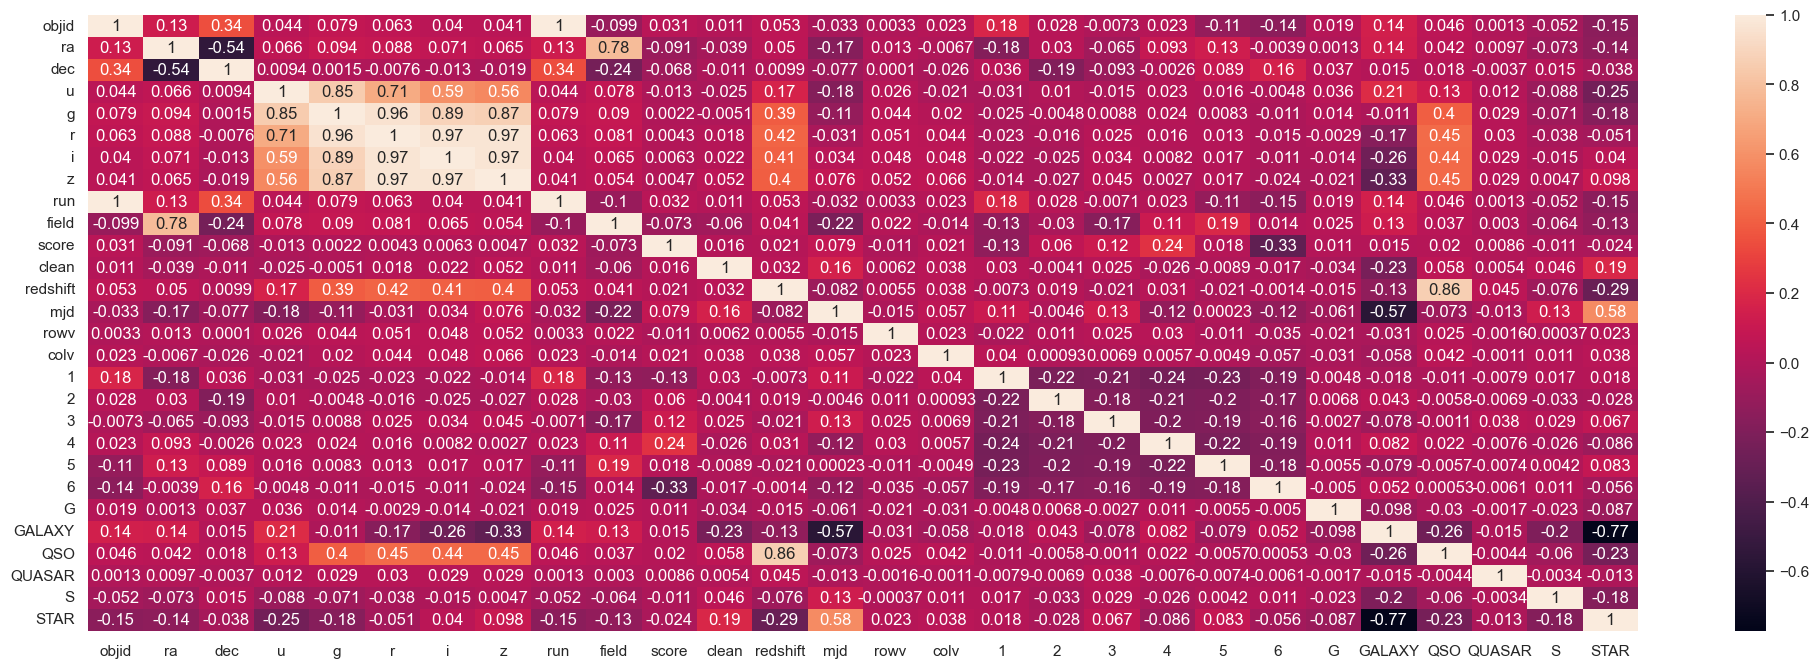

In [262]:
sb.set(rc={"figure.figsize":(25,8)})
sb.heatmap( data_t.corr(),annot=True )

### REGRESION LINEAL